# Setup

## Installation

## Library imports

The [RDKit library](https://github.com/rdkit/rdkit) provides a convenient, robust, and well tested interface for manipulating and drawing molecules.

In [1]:
from rdkit import Chem
from rdkit.Chem import RenumberAtoms, MolFromMolFile
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit import RDLogger                                                                                                                                                               
from tabulate import tabulate
from pathlib import Path
from collections import deque
import random
import re
import matplotlib.pyplot as plt
import networkx as nx
RDLogger.DisableLog('rdApp.*')

MOLFILEPATH = "../test/testfiles"

## Function definitions



In [20]:
def _draw_networkx_graph(m, ax=None, colormap=None):
  edges = [(b.GetBeginAtom().GetIdx(), b.GetEndAtom().GetIdx()) for b in m.GetBonds()]
  nx_graph = nx.from_edgelist(edges)
  partitions = [a.GetIntProp("partition") if a.HasProp("partition") else 0 for a in m.GetAtoms()]
  nx.set_node_attributes(nx_graph, {i:p for i, p in enumerate(partitions)}, "partition")
  partition_colors = [colormap[v] for v in nx.get_node_attributes(nx_graph, "partition").values()]
  nx.draw_kamada_kawai(nx_graph, node_color=partition_colors, node_size=1000, with_labels=True, ax=ax)

def draw_molecules(m_list, caption_list, highlight_partitions=False):
  cmap = plt.cm.tab20
  cmaplist = [cmap(i) for i in range(cmap.N)] if highlight_partitions else ["m"] * 20
  n_molecules = len(m_list)
  fig = plt.figure(figsize=(n_molecules * 6.4, 4.8))
  for i, m in enumerate(m_list):
    ax = fig.add_subplot(1, n_molecules, i + 1, title=caption_list[i])
    _draw_networkx_graph(m, ax, cmaplist)

def write_string_representation(m):
    atom_tuples = [tuple(sorted((a.GetIdx(), n.GetIdx()))) for a in m.GetAtoms() for n in a.GetNeighbors()]
    unique_atom_tuples = sorted(set((atom_tuples)))
    return f"{CalcMolFormula(m)}:{''.join([str(t) for t in unique_atom_tuples])}"

def build_molecule_from_string_representation(string_representation):
    sum_formula, atom_tuples = string_representation.split(":")
    atom_tuples = [list(map(int, list(map(str.strip, t.split(","))))) for t in atom_tuples[1:-1].split(")(")]
    n_atoms = sum([int(s) for s in re.findall(r'-?\d+', sum_formula)])
    m = Chem.Mol()
    em = Chem.RWMol(m)
    for _ in range(n_atoms):
        em.AddAtom(Chem.Atom(1))
    for t in atom_tuples:
        em.AddBond(*t, Chem.BondType.SINGLE)
    return em.GetMol()

def permute_molecule(m):
    permuted_indices = list(range(m.GetNumAtoms()))
    random.shuffle(permuted_indices)
    return RenumberAtoms(m, permuted_indices)

def print_molecule(m, caption=""):
    print(caption)
    table = []
    for atom in m.GetAtoms():
        idx = atom.GetIdx()
        num = atom.GetAtomicNum()
        partition = atom.GetIntProp("partition") if atom.HasProp("partition") else 0
        neighbors = [(n.GetIdx(),
                      n.GetAtomicNum(),
                      n.GetIntProp("partition") if n.HasProp("partition") else 0) for n in atom.GetNeighbors()]
        table.append([idx, num, partition, neighbors])
    print(tabulate(table, tablefmt="fancy_grid",
                   headers=["index", "atomic number", "partition", "neighbors (index, atomic number, partition)"]))





def _sort_molecule_by_property(m, sorting_property):
    prop_with_idcs = [(j, i) for i, j in enumerate(sorting_property)] # [(0, 0), (2, 1), (1, 2)]
    sorted_prop, idcs_sorted_by_prop = zip(*sorted(prop_with_idcs)) # (0, 1, 2), (0, 2, 1)
    return RenumberAtoms(m, idcs_sorted_by_prop)

def _atomic_number_sequence(atom):
    atomic_num = atom.GetAtomicNum()
    atomic_nums_neighbors = sorted([n.GetAtomicNum() for n in atom.GetNeighbors()], reverse=True)
    return [atomic_num] + atomic_nums_neighbors

def _partition_molecule_by_atomic_number(m):
    '''Mutates `m`'''
    for atom in m.GetAtoms():
        atom.SetIntProp("partition", 0) # initialize partitions
    current_partition = 0
    for i in range(m.GetNumAtoms() - 1):
        j = i + 1
        atomic_numbers_i = _atomic_number_sequence(m.GetAtomWithIdx(i))
        atomic_numbers_j = _atomic_number_sequence(m.GetAtomWithIdx(j))
        if (atomic_numbers_i != atomic_numbers_j): current_partition += 1 
        m.GetAtomWithIdx(j).SetIntProp("partition", current_partition)
    return m

def sort_molecule_by_atomic_numbers(m):
    '''Sort atoms lexicographically by atomic number. Also, within partitions
    where all atoms have the same atomic number, sort atoms lexicographically
    by the decreasing atomic numbers of their neighbors.
    '''
    atomic_numbers = [_atomic_number_sequence(atom) for atom in m.GetAtoms()]
    m_sorted = _sort_molecule_by_property(m, atomic_numbers)
    return _partition_molecule_by_atomic_number(m_sorted)

def _partition_sequence(atom):
    partition = atom.GetIntProp("partition")
    partitions_neighbors = sorted([n.GetIntProp("partition") for n in atom.GetNeighbors()], reverse=True)
    return [partition] + partitions_neighbors

def sort_molecule_by_partitions(m):
    partitions = [_partition_sequence(atom) for atom in m.GetAtoms()]
    return _sort_molecule_by_property(m, partitions)

def partition_molecule_recursively(m, show_steps=False):
    m_sorted = sort_molecule_by_partitions(m)
    if show_steps:
        print_molecule(m_sorted, "refined partitions")
    current_partitions = [a.GetIntProp("partition") for a in m.GetAtoms()]
    updated_partitions = [0]
    for i in range(m_sorted.GetNumAtoms() - 1):
        j = i + 1
        partitions_i = _partition_sequence(m_sorted.GetAtomWithIdx(i))
        partitions_j = _partition_sequence(m_sorted.GetAtomWithIdx(j))
        current_partition = updated_partitions[-1]
        if (partitions_i != partitions_j):
            current_partition += 1
        updated_partitions.append(current_partition)
    if current_partitions == updated_partitions:
        return m_sorted
    for i, atom in enumerate(m_sorted.GetAtoms()):
        atom.SetIntProp("partition", updated_partitions[i])
    return partition_molecule_recursively(m_sorted, show_steps=show_steps)

def bfs_molecule(m):
    for a in m.GetAtoms():
        a.SetBoolProp("explored", False)
    root_atom = m.GetAtomWithIdx(0)
    root_atom.SetBoolProp("explored", True)
    atom_queue = deque([root_atom])
    while atom_queue:
        atom = atom_queue.popleft()
        for n in atom.GetNeighbors():
            if n.GetBoolProp("explored"):
                continue
            n_neighbors = n.GetNeighbors()
            if len([nn.GetIntProp("partition") for nn in n_neighbors]) != len(n_neighbors):
                continue
            print(atom.GetIdx(), n.GetIdx())
            n.SetBoolProp("explored", True)
            atom_queue.append(n)
    

# Serialization

The serialization should result in a string representation of the molecule. The string representation should allow for the automatized reconstruction of the molecule's topology (i.e., the molecular graph). Additionally, ideally the representation should be intuitive enough for a human to be able to reconstruct the molecular graph.

Our string representation consists of the sum formula, followed by a sequence of tuples. Each tuple represents the indices of two connected atoms (i.e., `(index X, index Y)`). For example, the string representation of ethanol is `C2H6O:(0,6)(1,6)(2,6)(3,7)(4,7)(5,8)(6,7)(7,8)`.
In order to be able to reconstruct the molecule based on this representation, we organize the tuples such that increasing indices pertain to atoms with increasing atomic number. This means that we can infer an atom's atomic number from the sum formula. Let's illustrate this with the ethanol example above. The sum formula of ethanol indicates that the molecule consists of six `H`s, two `C`s and one `O`. Since increasing indices pertain to atoms with increasing atomic number, we can infer that the indices 0 to 6 pertain to `H`s, indices 7 and 8 pertain to `C`s, and finally, index 8 pertains to an `O`.

This string representation cannot be derived from the original molecule, since increasing atom indices do not pertain to increasing atomic numbers. Therefore, we sort the molecule's atoms by atomic number. However, in a typical molecule there are multiple atoms with the same atomic number. Consider for example the five `C` atoms below (atomic number 6). To further differentiate these `C` atoms, we rank them [lexicographically](https://en.wikipedia.org/wiki/Lexicographic_order) by the atomic numbers of their neighbours. More specifically, for each atom `A` we construct a list of the atomic numbers of `A`'s neighbors, like so:

| index | list of neighboring atomic number |
|-------|-----------------------------------|
| 4     | [7, 6, 6] |
| 5     | [7, 7] |
| 6     | [7, 7, 6] |
| 7     | [7, 7, 7] |
| 8     | [8, 7, 6] |

Note that each list of neighboring atomic numbers is sorted in decreasing order. This ensures that the lexicographic sorting, ranks atoms with identical atomic numbers by their "largest" neighbors (in terms of atomic numbers).


Subsequently, the molecule is partitioned such that the following is true for the atoms that share a partition: elaborate

Note that the recursive partitioning almost shatters the molecule. That is, most partitions contain only a single molecule. In this case, the exception to this shattering are the atoms with index 0 and 1, as they both belong to partition 0. If our serialization would completely shatter the molecule, the serialization itself would serve as canonicalization, since the goal of canonicalization is to uniquely identify each atom. 

original
╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               6 │           0 │ [(1, 6, 0), (5, 6, 0), (11, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               6 │           0 │ [(0, 6, 0), (2, 6, 0), (12, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               6 │           0 │ [(1, 6, 0), (3, 6, 0), (13, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               6 │           0 │ [(2, 6, 0), (4, 6, 0), (6, 6, 0)]             │
├─────────┼─────────────────┼─────────────┼────────────────────────────

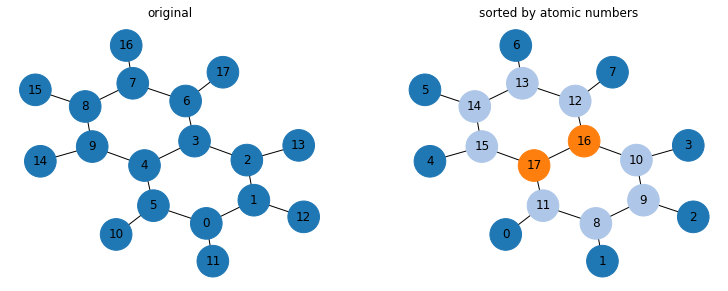

In [3]:
molecule = "naphthalene"
m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
print_molecule(m, "original")
print_molecule(m_sorted_by_atomic_numbers, "sorted by atomic number")
draw_molecules([m, m_sorted_by_atomic_numbers], ["original", "sorted by atomic numbers"], highlight_partitions=True)


╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               1 │           0 │ [(8, 6, 2)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               1 │           0 │ [(9, 6, 2)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               1 │           0 │ [(11, 6, 2)]                                  │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               1 │           0 │ [(10, 6, 2)]                                  │
├─────────┼─────────────────┼─────────────┼────────────────────────────────────

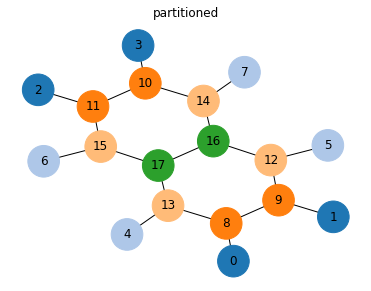

In [4]:
m_partitioned = partition_molecule_recursively(m_sorted_by_atomic_numbers, show_steps=False)
print_molecule(m_partitioned)
draw_molecules([m_partitioned], ["partitioned"], highlight_partitions=True)

root: 0
(0, 10)
(10, 11)
(10, 15)
(11, 14)
(11, 1)
(15, 21)
(15, 4)
(14, 20)
(14, 5)
root: 1
root: 2
(2, 13)
(13, 12)
(13, 17)
(12, 16)
(12, 3)
(17, 23)
(17, 6)
(16, 22)
(16, 7)
root: 3
root: 4
root: 5
root: 6
root: 7
root: 8
root: 9
root: 10
root: 11
root: 12
root: 13
root: 14
root: 15
root: 16
root: 17
root: 18
root: 19
root: 20
root: 21
root: 22
root: 23
[(0, 10), (10, 11), (10, 15), (11, 14), (11, 1), (15, 21), (15, 4), (14, 20), (14, 5), (2, 13), (13, 12), (13, 17), (12, 16), (12, 3), (17, 23), (17, 6), (16, 22), (16, 7)]


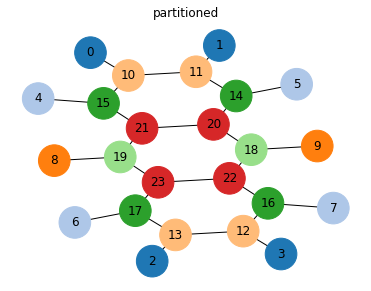

In [5]:
molecule = "anthracene"
m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
m_partitioned = partition_molecule_recursively(m_sorted_by_atomic_numbers, show_steps=False)


for a in m_partitioned.GetAtoms():
    a.SetBoolProp("explored", False)

tuples = []
for a in m_partitioned.GetAtoms():
# def bfs_molecule(root_atom):
    print("root:", a.GetIdx())
    root_atom = a
    root_atom.SetBoolProp("explored", True)
    atom_queue = deque([root_atom])
    while atom_queue:
        atom = atom_queue.popleft()
        for n in atom.GetNeighbors():
            if n.GetBoolProp("explored"):
                continue
            n_neighbors = n.GetNeighbors()
            if len({nn.GetIntProp("partition") for nn in n_neighbors}) != len(n_neighbors):
                continue
            bond = (atom.GetIdx(), n.GetIdx())
            print(bond)
            tuples.append(bond)
            n.SetBoolProp("explored", True)
            atom_queue.append(n)

print(tuples)
draw_molecules([m_partitioned], ["partitioned"], highlight_partitions=True)



Finally, we write the string representation for the molecule.

In [6]:
string = write_string_representation(m_partitioned)
print(string)

C14H10:(0, 10)(1, 11)(2, 13)(3, 12)(4, 15)(5, 14)(6, 17)(7, 16)(8, 19)(9, 18)(10, 11)(10, 15)(11, 14)(12, 13)(12, 16)(13, 17)(14, 20)(15, 21)(16, 22)(17, 23)(18, 20)(18, 22)(19, 21)(19, 23)(20, 21)(22, 23)


# Invariance Test
In order to be useful for the identification of a molecule, the serialization must be invariant. That is, irrespective of a molecule's initial atom labels, the serialization should always result in the same string representation. Below we set up a simple test of invariance. 

In [7]:
testfiles = list(Path(MOLFILEPATH).glob("*/*.mol"))

    
def load_molfile(path):
    m = MolFromMolFile(str(path), removeHs=False)
    try:
        # Unfortunately, RDKit exceptions cannot be caught. However, MolFromMolFile returns None if validation fails.
        n_atoms = m.GetNumAtoms() # Raises AttributeError in case m_original is None.
        if n_atoms < 1:
            raise Exception(f"Molecule has < 1 ({n_atoms}) atoms")
        return m
    except Exception as e:
#         print(f"Failed loading {str(molfile)}: {e}.")
        return None
 
def test_invariance(m):
    m_permuted = permute_molecule(m)

    m_sorted = sort_molecule_by_atomic_numbers(m)
    m_permuted_sorted = sort_molecule_by_atomic_numbers(m_permuted)
    
    string_original = write_string_representation(partition_molecule_recursively(m_sorted))
    string_permuted = write_string_representation(partition_molecule_recursively(m_permuted_sorted))
    
    try:
        assert string_original == string_permuted, f"{string_original}\ndoesn't match\n{string_permuted}"
        print(f"{string_original}\nmatches\n{string_permuted}")
        return True
    except AssertionError as e:
        print(e)
        return False

n_failed_molecules = 0
n_molecules = 0
for molfile in testfiles:
    m = load_molfile(molfile)
    if not m: continue
    print(f"\nTesting {str(molfile)} for invariance...\n")
    if not test_invariance(m): n_failed_molecules += 1
    n_molecules += 1
        
print(f"{n_failed_molecules}/{n_molecules} failures")


Testing ../test/testfiles/2-8-dimethyldecane/2-8-dimethyldecane.mol for invariance...

C12H26:(0, 26)(1, 26)(2, 26)(3, 27)(4, 27)(5, 27)(6, 28)(7, 28)(8, 28)(9, 29)(10, 29)(11, 29)(12, 30)(13, 30)(14, 31)(15, 31)(16, 32)(17, 32)(18, 33)(19, 33)(20, 34)(21, 34)(22, 35)(23, 35)(24, 36)(25, 37)(26, 33)(27, 36)(28, 36)(29, 37)(30, 31)(30, 32)(31, 34)(32, 35)(33, 37)(34, 36)(35, 37)
doesn't match
C12H26:(0, 26)(1, 26)(2, 26)(3, 27)(4, 28)(5, 28)(6, 27)(7, 27)(8, 28)(9, 29)(10, 29)(11, 29)(12, 30)(13, 30)(14, 31)(15, 31)(16, 32)(17, 32)(18, 33)(19, 33)(20, 34)(21, 34)(22, 35)(23, 35)(24, 36)(25, 37)(26, 33)(27, 36)(28, 36)(29, 37)(30, 31)(30, 32)(31, 34)(32, 35)(33, 37)(34, 36)(35, 37)

Testing ../test/testfiles/2-aminopyridine/2-aminopyridine.mol for invariance...

C5H6N2:(0, 6)(1, 7)(2, 8)(3, 9)(4, 11)(5, 11)(6, 7)(6, 8)(7, 9)(8, 10)(9, 12)(10, 11)(10, 12)
matches
C5H6N2:(0, 6)(1, 7)(2, 8)(3, 9)(4, 11)(5, 11)(6, 7)(6, 8)(7, 9)(8, 10)(9, 12)(10, 11)(10, 12)

Testing ../test/testfiles/acety

# Failed test cases:

* benzene (6-ring)
* bipyridine (2 adjacent 6-rings)
* cyclophane1 (2 embedded 6-rings)
* norbornadiene
* tpp
* cyclobutane (4-ring)


# General observations

Atoms must not necessarily be in unique partitions, but...
There musn't be duplicate partitions in any atom's neighbors.
If there aren't duplicates in any atom's neighbors, the molecular graph can be traversed deterministically by branching in a principled way.

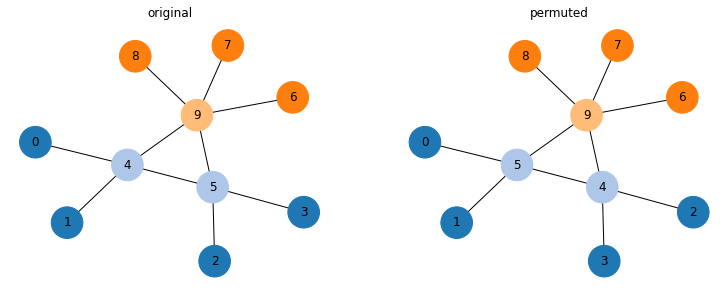

In [22]:
molecule = "zeise_salz"

m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
m_permu = permute_molecule(m)

m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
m_permu_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m_permu)

m_partitioned = partition_molecule_recursively(m_sorted_by_atomic_numbers, show_steps=False)
m_permu_partitioned = partition_molecule_recursively(m_permu_sorted_by_atomic_numbers, show_steps=False)

print_molecule(m_partitioned, "original")
print_molecule(m_permu_partitioned, "permuted")

string_m = write_string_representation(m_partitioned)
string_m_permu = write_string_representation(m_permu_partitioned)

draw_molecules([m_partitioned, m_permu_partitioned], ["original", "permuted"], highlight_partitions=True)